In [ ]:
from google.colab import drive

# 1. Google Drive 마운트
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 2. 파일 경로 설정 (사용자 지정 경로)
data_root = '/content/drive/MyDrive/Colab Notebooks/datathon/주력_비주력상품 데이터/비주력상품'
# file_path = f'{data_root}/2019-Nov.csv'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import os

In [ ]:
sns.set()

# 그래프 기본 설정
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False
import matplotlib as mpl
import matplotlib.font_manager as fm

# 폰트 파일 경로 지정
font_path = '/content/drive/MyDrive/font/NanumGothic.ttf'

# 폰트 등록 및 matplotlib 설정
font_name = fm.FontProperties(fname=font_path).get_name()
fm.fontManager.addfont(font_path)
mpl.rc('font', family=font_name)

In [ ]:
# 데이터 불러오기
notop_multi_df = pd.read_parquet(f'{data_root}/noTop3_multi_buyers_all_events.parquet')

다회 구매자의 첫 구매 행동 패턴 분석

In [ ]:
# 첫 구매 이전 cart -> purchase 시간 계산
# 1. event_datetime 컬럼 생성
notop_multi_df['event_datetime'] = notop_multi_df['event_date'] + pd.to_timedelta(notop_multi_df['event_hour'], unit='h')
notop_multi_df['event_datetime'] = pd.to_datetime(notop_multi_df['event_datetime'])

# 2. 각 유저의 첫 purchase 시간 구하기
first_purchase_time = notop_multi_df[notop_multi_df['event_type'] == 'purchase'] \
                        .groupby('user_id')['event_datetime'].min() \
                        .rename('first_purchase_time')

# 3. 첫 구매 이전의 행동만 필터링
notop_multi_df = notop_multi_df.join(first_purchase_time, on='user_id')
notop_multi_df_first_purchase = notop_multi_df[notop_multi_df['event_datetime'] <= notop_multi_df['first_purchase_time']].copy()

# 4. 해당 구간 내에서 cart/purchase 시점 추출
df_cart = notop_multi_df_first_purchase[notop_multi_df_first_purchase['event_type'] == 'cart']
df_purchase = notop_multi_df_first_purchase[notop_multi_df_first_purchase['event_type'] == 'purchase']

cart_times = df_cart.groupby('user_id')['event_datetime'].min()
purchase_times = df_purchase.groupby('user_id')['event_datetime'].min()

# 5. 공통 user_id 기준 병합 및 시간 차 계산 (단위: 시간)
merged = pd.merge(cart_times, purchase_times, on='user_id', suffixes=('_cart', '_purchase'))
cart_hold_time_first_purchase = (merged['event_datetime_purchase'] - merged['event_datetime_cart']).dt.total_seconds() / 3600


/tmp/ipython-input-227842798.py:3: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized.
  notop_multi_df['event_datetime'] = notop_multi_df['event_date'] + pd.to_timedelta(notop_multi_df['event_hour'], unit='h')


In [ ]:
print("평균 Cart 보유 시간 (시간):", cart_hold_time_first_purchase.mean())

평균 Cart 보유 시간 (시간): 119.36585418301848


In [ ]:
print(cart_hold_time_first_purchase.describe())

count    186014.000000
mean        119.365854
std         374.487087
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4200.000000
dtype: float64


In [ ]:
# 즉시 구매자 비율 확인
instant_buyers_ratio = (cart_hold_time_first_purchase == 0).mean() * 100
print(f"즉시 구매자 비율: {instant_buyers_ratio:.2f}%")

즉시 구매자 비율: 77.52%


1회 구매 고객과 비교 위한 행동 흐름 분석

In [ ]:
#1.구매 간격(재구매 주기)
# event_date를 datetime으로 변환
notop_multi_df['event_date'] = pd.to_datetime(notop_multi_df['event_date'])

# 구매 이벤트만 추출
purchase_notop_multi_df = notop_multi_df[notop_multi_df['event_type'] == 'purchase']

# 유저별 구매 일자 정렬
purchase_notop_multi_df = purchase_notop_multi_df.sort_values(by=['user_id', 'event_date'])

# 각 유저의 구매 간격 계산 (days)
purchase_notop_multi_df['purchase_gap'] = purchase_notop_multi_df.groupby('user_id')['event_date'].diff().dt.days

# 평균 구매 간격
avg_gap = purchase_notop_multi_df['purchase_gap'].mean()
print(f"평균 구매 간격(일): {avg_gap}")

평균 구매 간격(일): 8.708703408219074


In [ ]:
#2. 구매 전 행동 흐름
# 구매가 발생한 세션 이전 이벤트 시퀀스 파악
# 구매 이벤트가 있는 세션 ID 추출
purchase_sessions = notop_multi_df[notop_multi_df['event_type'] == 'purchase']['user_session'].unique()

# 해당 세션의 이벤트 순서 (view, cart, purchase)
funnel_sequence = (notop_multi_df[notop_multi_df['user_session'].isin(purchase_sessions)]
                   .groupby('user_session')['event_type']
                   .apply(list))

print(funnel_sequence.head(10))  # 세션별 행동 흐름 샘플

user_session
00000361-1394-4fe6-a29b-4bed6c17193a                               [view, cart, purchase]
00001739-fd8f-4d65-b8c8-bb82e3e5af3a                               [view, cart, purchase]
00004e71-576e-4dd6-b322-0639305153a6                               [view, cart, purchase]
00005479-86e4-4988-b8b5-5ec5cabdb04d    [view, view, view, view, view, view, cart, pur...
00005e37-2de6-45af-a682-2fe5595fdd7e             [view, view, view, cart, purchase, view]
00006211-94ee-44ad-9fb1-a4bca0710818             [view, cart, view, view, cart, purchase]
00007576-a35c-4704-b276-3fecef2f6fc2             [view, view, view, cart, purchase, view]
00009f76-cbe9-46a7-8185-36dcddbd3c56    [view, view, view, view, view, cart, purchase,...
0000d0db-62c8-484e-a493-f5390b14f6d1    [view, view, view, view, view, view, view, vie...
0000dbc1-c195-4448-b3d4-40aff9d0a5b8                         [view, cart, purchase, view]
Name: event_type, dtype: object


In [ ]:
#3. 세션 수 & 행동량 분석
# 유저별 세션 수
user_session_count = notop_multi_df.groupby('user_id')['user_session'].nunique()

# 유저별 이벤트 수
user_event_count = notop_multi_df.groupby('user_id')['event_type'].count()

print(f"평균 세션 수: {user_session_count.mean()}")
print(f"평균 이벤트 수: {user_event_count.mean()}")

평균 세션 수: 17.667503649635037
평균 이벤트 수: 96.82905109489052


In [ ]:
#4. 카테고리/브랜드 다양성
# 유저별 탐색 카테고리 수
user_category_diversity = notop_multi_df.groupby('user_id')['category_lvl1'].nunique()

# 유저별 브랜드 수
user_brand_diversity = notop_multi_df.groupby('user_id')['brand'].nunique()

print(f"평균 탐색 카테고리 수: {user_category_diversity.mean()}")
print(f"평균 브랜드 수: {user_brand_diversity.mean()}")

평균 탐색 카테고리 수: 3.9259805352798054
평균 브랜드 수: 14.094277372262773


In [ ]:
#5. 요일/시간대 분석
# 요일별 구매 수
weekday_purchase = purchase_notop_multi_df['weekday'].value_counts()

# 시간대별 구매 수
hour_purchase = purchase_notop_multi_df['event_hour'].value_counts().sort_index()

print("요일별 구매 수:\n", weekday_purchase)
print("시간대별 구매 수:\n", hour_purchase)

요일별 구매 수:
 weekday
Monday       131687
Sunday       130419
Tuesday      120973
Wednesday    116758
Friday       115771
Saturday     115193
Thursday     112070
Name: count, dtype: int64
시간대별 구매 수:
 event_hour
0     26301
1     16846
2     10441
3      6551
4      4647
5      4478
6      6235
7     13602
8     27780
9     41839
10    49349
11    52951
12    55038
13    57909
14    58461
15    56640
16    52643
17    48430
18    46544
19    44388
20    43725
21    42673
22    40440
23    34960
Name: count, dtype: int64


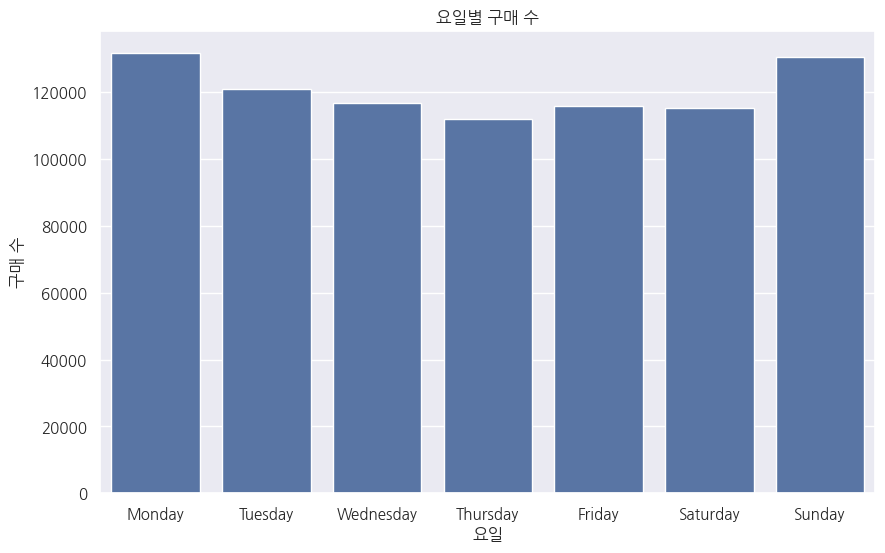

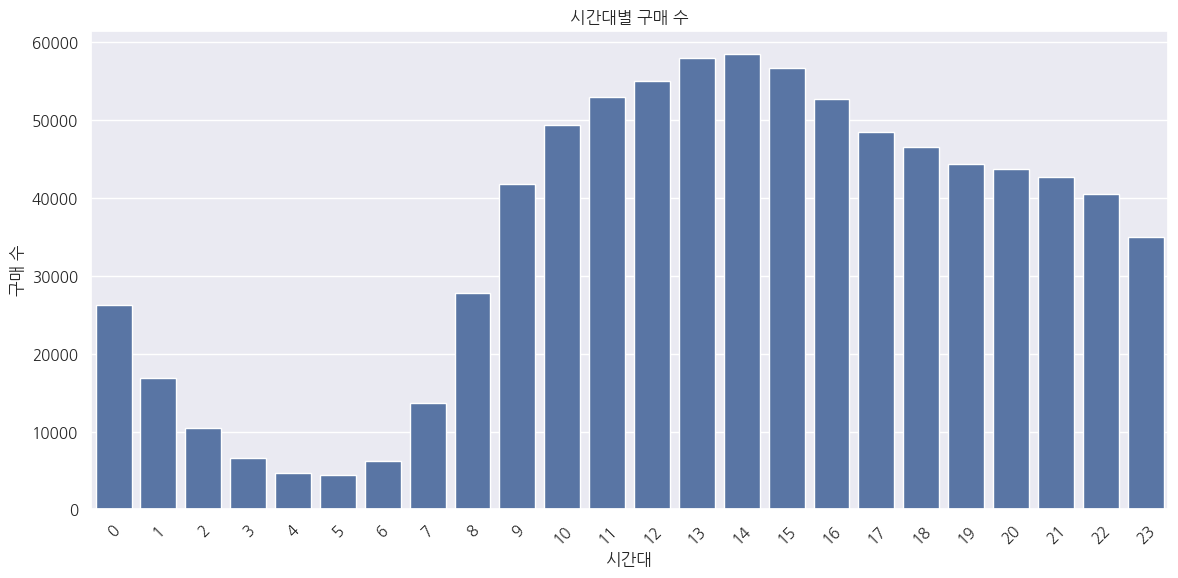

In [ ]:
# 요일별 구매 수 시각화
plt.figure(figsize=(10, 6))
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.barplot(x=weekday_purchase.index, y=weekday_purchase.values, order=weekday_order) # order를 지정하여 월~일 순서대로 정렬
plt.title('요일별 구매 수')
plt.xlabel('요일')
plt.ylabel('구매 수')
plt.show()

# 시간대별 구매 수 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x=hour_purchase.index, y=hour_purchase.values)
plt.title('시간대별 구매 수')
plt.xlabel('시간대')
plt.ylabel('구매 수')
plt.xticks(rotation=45) # 시간대 레이블이 겹치지 않도록 회전
plt.tight_layout() # 그래프 레이아웃 자동 조정
plt.show()